In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import spotpy
from scipy import stats, signal, optimize
import hydroeval as he
import os.path
from scipy.stats import spearmanr
import pickle

In [2]:
# load primary data
data = xr.load_dataset('../data/hydro_krummh.nc').to_dataframe()
data.head()
data = data['2016':'2018']   # Q_Knock is only available in this time period

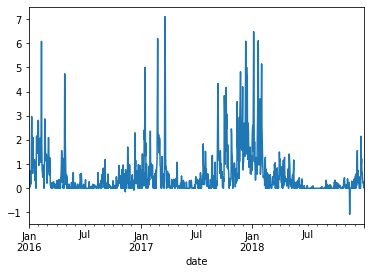

In [3]:
data.Q_Knock.resample('1d').sum().plot()

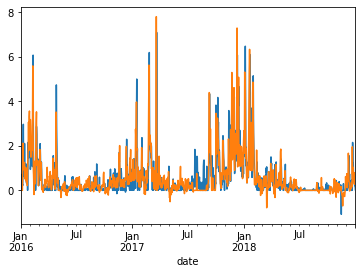

In [4]:
data['Q_Knock'].resample('1d').sum().plot()
x = [1., 2170.]
(((data['wl_LW'] - data['wl_Knock_Inner'])**x[0]).resample('1d').sum()/x[1]).plot()


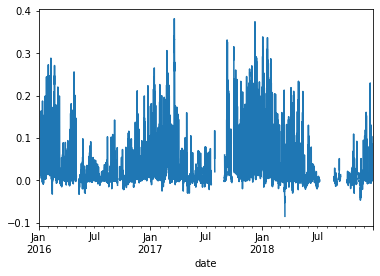

In [5]:
(((data['wl_LW'] - data['wl_Knock_Inner'])**x[0])/x[1]).plot()

In [6]:
def optidhQ (x):
    return -he.kge(((data['wl_LW'] - data['wl_Knock_Inner'])**x[0]).resample('1d').sum().values/x[1], data['Q_Knock'].resample('1d').sum().values)[0][0]

import scipy
dhQ = scipy.optimize.minimize(fun = optidhQ, x0 = [1., 2170.], method='Nelder-Mead', tol=1e-6)
print(dhQ)


 final_simplex: (array([[1.0000e+00, 2.2785e+03],
       [1.0000e+00, 2.2785e+03],
       [1.0000e+00, 2.2785e+03]]), array([-0.72968788, -0.72968788, -0.72968788]))
           fun: -0.729687881205299
       message: 'Optimization terminated successfully.'
          nfev: 199
           nit: 57
        status: 0
       success: True
             x: array([1.0000e+00, 2.2785e+03])


[[0.72968788]
 [0.73131284]
 [0.97070892]
 [1.00422867]]


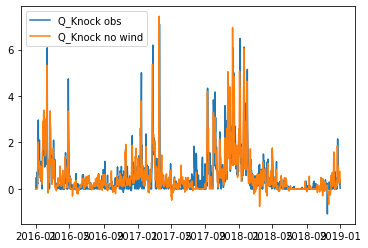

In [7]:
plt.plot(data['Q_Knock'].resample('1d').sum(), label ='Q_Knock obs')
plt.plot(((data['wl_LW'] - data['wl_Knock_Inner'])**dhQ.x[0]).resample('1d').sum() / dhQ.x[1], label ='Q_Knock no wind')
plt.legend()

print(he.kge(((data['wl_LW'] - data['wl_Knock_Inner'])**dhQ.x[0]).resample('1d').sum().values/dhQ.x[1], data['Q_Knock'].resample('1d').sum().values))

In [8]:
class spotpy_setup(object):
    def __init__(self):
        self.params = [spotpy.parameter.Uniform('exponent',low=0.1 , high=5,  optguess=1),   # exponent in flow equatoion (non-linear relation of dh-Q)
                       spotpy.parameter.Uniform('factor',low=0.01 , high=10000,  optguess=2500)     # factor in flow equatoion (linear relation of dh-Q)
                       ]
        self.evals = data['Q_Knock'].resample('1d').sum().values

    def parameters(self):
        a = spotpy.parameter.generate(self.params)
        return a
    
    def simulation(self,x):
        sim = ((data['wl_LW'] - data['wl_Knock_Inner'])**x[0]).resample('1d').sum().values/x[1]
        return sim 
    
    def evaluation(self):
        return self.evals
    
    def objectivefunction(self,simulation,evaluation, params=None, print_sublikes = False):

        import hydroeval as he
        like = he.kge(simulation, evaluation)[0][0]
        return max([like, -10])

In [9]:
spot_setup=spotpy_setup()

dbname='LHS_dh_Q'
#dbname='DREAM_WR_seepage_cs2_'+usgb+'_'+ETmeth

sampler=spotpy.algorithms.lhs(spot_setup, dbname=dbname, dbformat='csv')

#Select number of maximum repetitions
rep = 15000

# Select five chains and set the Gelman-Rubin convergence limit
nChains                = 6
convergence_limit      = 1.01
runs_after_convergence = 500

In [10]:
## To test setup convert this cell to code type
x = spotpy_setup.parameters(spot_setup)['random']
#x = dhQ.x
print(x)
a = spot_setup.simulation(x)

b = spot_setup.evaluation()
spot_setup.objectivefunction(a,b)

[3.74480555e+00 8.03635340e+03]


-10

In [11]:
try: 
    results = spotpy.analyser.load_csv_results('LHS_dh_Q')
except:
    r_hat = sampler.sample(rep)
    results=sampler.getdata()

In [12]:
posterior = results[results['like1']>0.72]
print(spotpy.analyser.get_parameters(posterior))

[(1.13  , 4530.) (1.132 , 4616.) (1.023 , 2556.) (1.102 , 4188.)
 (1.122 , 4420.) (1.075 , 3294.) (1.058 , 3158.) (0.967 , 1888.)
 (1.097 , 4078.) (1.126 , 4504.) (1.184 , 6400.) (1.106 , 4260.)
 (1.121 , 4680.) (1.169 , 5860.) (1.165 , 5570.) (1.161 , 5708.)
 (1.061 , 3200.) (1.1455, 5350.) (0.992 , 2246.) (1.164 , 5510.)
 (1.045 , 2972.) (1.034 , 2710.) (1.105 , 3910.) (1.171 , 5908.)
 (1.127 , 4830.) (1.151 , 5292.) (1.027 , 2720.) (1.174 , 6180.)
 (1.042 , 2986.)]


In [13]:
for z in spotpy.analyser.get_parameters(posterior):
    print((1000**z[0])/z[1])

0.5418783478333395
0.5391805282240877
0.45860538558221037
0.48305137981811674
0.5255060625242327
0.5096551360420644
0.4727024729509173
0.42169457119561365
0.47923968998906186
0.5301534819967086
0.5569548959785063
0.4881917105877223
0.4928946984444592
0.5484062352628529
0.5612350748876043
0.532740894477274
0.47626648556165335
0.5106769053978477
0.421298825185126
0.5634409415840933
0.4591464120420336
0.4666923791406464
0.5282302188773732
0.5515177742078688
0.49779768116085577
0.5362658783903168
0.4430279192543371
0.5382840668187773
0.4476207356150176


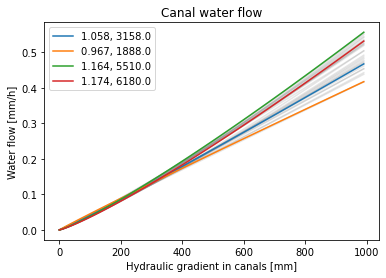

In [27]:
x = np.arange(0,1000,10)

fig, ax = plt.subplots()

for z in spotpy.analyser.get_parameters(posterior):
    ax.plot(x, (x**z[0])/z[1], alpha = 0.2, color = 'grey')
posterior_sel = spotpy.analyser.get_parameters(posterior)[[6,7,19,27]]
for z in posterior_sel:
    ax.plot(x, (x**z[0])/z[1], label = str(z[0])+', '+str(z[1]))

ax.set_xlabel("Hydraulic gradient in canals [mm]")
ax.set_ylabel("Water flow [mm/h]")
ax.set_title("Canal water flow")
ax.legend()

plt.show()

In [25]:
with open('cache/canals.pkl', 'wb') as file:
    myvar = pickle.dump(posterior_sel, file)